# Model Training

In [1]:
import pandas as pd

from config import TEST_DATA_PATH, RESULTS_PATH, TARGET_NAME, TEST_SIZE, RANDOM_STATE, TARGET_NAME, MODEL_PATH

# supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [39]:
import importlib
import utils.visualisation
import utils.metrics

# reload custom libraries without restarting Kernel
importlib.reload(utils.visualisation)
importlib.reload(utils.metrics)

from utils.visualisation import display_df, summarize_df
from utils.metrics import plot_confusion, plot_roc_curve, plot_feature_importance, plot_predictions_vs_truth, plot_prediction_errors, plot_error_summary
from utils.metrics import log_model_result, plot_decision_tree, export_tree_to_pdf
from utils.metrics import generate_rename_map
from utils.metrics import evaluate_model_cv

from utils.visualisation import plot_permutation_importance, plot_partial_dependence_wrapper
from utils.visualisation import plot_shap_summary, plot_shap_dependence, plot_shap_force_for_instance, explain_passenger


In [3]:
# encoding, scaling, split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

# hyperparameters
from sklearn.model_selection import GridSearchCV

In [5]:
# Global results DataFrame to accumulate model results
results_df = pd.DataFrame(columns=[
    "model_name", "params", "accuracy", "precision", "recall", "f1", "roc_auc", "training_time", "notes"
])


### Load prepared dataset

- Load titanic_ready.pkl (after feature engineering and rare category handling)

In [6]:
# Load cleaned data
df = pd.read_pickle(RESULTS_PATH+"titanic_ready.pkl")

# original date
df_original = pd.read_pickle(RESULTS_PATH+"titanic_clean.pkl")

# Quick overview
display_df(df)
summarize_df(df, mode="basic")

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Embarked,Title,FamilySize,IsAlone,Deck,AgeGroup,Fare,FareBand,TicketPrefix
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,S,Mr,2,0,Unknown,young,7.25,0.0,Other
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,C,Mrs,2,0,C,adult,70.00,50.0,PC
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,S,Miss,1,1,Unknown,young,7.90,7.5,Other
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,S,Mrs,2,0,C,adult,50.00,25.0,
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,S,Mr,1,1,Unknown,adult,8.05,7.5,
6,0,3,"Moran, Mr. James",male,30.0,0,0,330877,Q,Mr,1,1,Unknown,young,8.45,7.5,
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,S,Mr,1,1,E,adult,50.00,25.0,
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,S,Master,5,0,Unknown,kids<3,20.00,15.0,
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,S,Mrs,3,0,Unknown,young,11.00,7.5,
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,C,Mrs,2,0,Unknown,teenager,30.00,25.0,



========== Dataset Summary ==========

Shape: 891 rows × 18 columns

🧾 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   891 non-null    int64   
 1   Survived      891 non-null    int64   
 2   Pclass        891 non-null    int64   
 3   Name          891 non-null    object  
 4   Sex           891 non-null    object  
 5   Age           891 non-null    float64 
 6   SibSp         891 non-null    int64   
 7   Parch         891 non-null    int64   
 8   Ticket        891 non-null    object  
 9   Embarked      891 non-null    object  
 10  Title         891 non-null    object  
 11  FamilySize    891 non-null    int64   
 12  IsAlone       891 non-null    int64   
 13  Deck          891 non-null    object  
 14  AgeGroup      891 non-null    category
 15  Fare          891 non-null    float64 
 16  FareBand  

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Embarked,Title,FamilySize,IsAlone,Deck,AgeGroup,Fare,FareBand,TicketPrefix
count,891.00,891.00,891.00,891,891,891.00,891.00,891.00,891,891,891,891.00,891.00,891,891,891.00,891.00,891
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,3,5,NaN,NaN,7,7,NaN,NaN,5
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,S,Mr,NaN,NaN,Unknown,young,NaN,NaN,
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,646,517,NaN,NaN,687,521,NaN,NaN,661
mean,446.00,0.38,2.31,NaN,NaN,29.41,0.52,0.38,NaN,NaN,NaN,1.90,0.60,NaN,NaN,32.10,17.29,NaN
std,257.35,0.49,0.84,NaN,NaN,13.25,1.10,0.81,NaN,NaN,NaN,1.61,0.49,NaN,NaN,49.52,15.78,NaN
min,1.00,0.00,1.00,NaN,NaN,0.42,0.00,0.00,NaN,NaN,NaN,1.00,0.00,NaN,NaN,0.00,0.00,NaN
25%,223.50,0.00,2.00,NaN,NaN,21.50,0.00,0.00,NaN,NaN,NaN,1.00,0.00,NaN,NaN,7.90,7.50,NaN
50%,446.00,0.00,3.00,NaN,NaN,30.00,0.00,0.00,NaN,NaN,NaN,1.00,1.00,NaN,NaN,14.50,7.50,NaN
75%,668.50,1.00,3.00,NaN,NaN,35.00,1.00,0.00,NaN,NaN,NaN,2.00,1.00,NaN,NaN,30.00,25.00,NaN



❓ Missing Values:
✅ No missing values.

🔁 Duplicated rows: 0



### Define feature groups
Separate target, categorical and numerical features (if needed)

In [7]:
# Define target and features
target = TARGET_NAME

# Drop identifier and non-informative features
drop_cols = ["PassengerId", "Name", "Ticket"]

# Categorical features
categorical_features = [
    "Sex", "Embarked", "Title", "Deck", "AgeGroup", "TicketPrefix", "IsAlone"
]

# Numerical features
numerical_features = [
    "Pclass", "Age", "SibSp", "Parch", "FamilySize", "FareBand"
]

used_features = categorical_features + numerical_features

# Optionally check if columns exist
print("Target:", target)
print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)


Target: Survived
Categorical features: ['Sex', 'Embarked', 'Title', 'Deck', 'AgeGroup', 'TicketPrefix', 'IsAlone']
Numerical features: ['Pclass', 'Age', 'SibSp', 'Parch', 'FamilySize', 'FareBand']


### Encode features and prepare data for modeling

We apply ordinal encoding for categorical features and optionally scale numerical features.  
For tree-based models, scaling is usually not required.

#### Split dataset into train/test
- Use stratified split for balanced classification

In [58]:
# Drop non-used columns
df_model = df.drop(columns=drop_cols)

# Split target and features (before encoding! to avoid data leakage)
X = df_model[used_features].copy()
y = df_model[target]

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

#### Ordinal Encoding

- We encode ordinal features like AgeGroup using a predefined category order.

In [59]:
# Ordered categories (AgeGroup only)
ordinal_cols = ['AgeGroup']
ordinal_categories = [['baby', 'kids<3', 'kids<12', 'teenager', 'young', 'adult', 'senior']]

ordinal_encoder = OrdinalEncoder(
    categories=ordinal_categories,
    handle_unknown='use_encoded_value',
    unknown_value=-1,
    dtype=int
)


X_train[ordinal_cols] = ordinal_encoder.fit_transform(X_train[ordinal_cols])
X_test[ordinal_cols] = ordinal_encoder.transform(X_test[ordinal_cols])

#### One-Hot Encoding

- We apply OneHotEncoding to the remaining categorical variables.
- Drop the first category to avoid multicollinearity.
- Ignore unknown categories in the test set.

In [60]:
# Get categorical columns excluding Ordinal ones
categorical_ohe_cols = list(set(categorical_features) - set(ordinal_cols))

ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# Fit-transform train
X_train_ohe = pd.DataFrame(
    ohe.fit_transform(X_train[categorical_ohe_cols]),
    columns=ohe.get_feature_names_out(categorical_ohe_cols),
    index=X_train.index
)

# Transform test
X_test_ohe = pd.DataFrame(
    ohe.transform(X_test[categorical_ohe_cols]),
    columns=ohe.get_feature_names_out(categorical_ohe_cols),
    index=X_test.index
)

# Drop old and concat encoded
X_train = pd.concat([X_train.drop(columns=categorical_ohe_cols), X_train_ohe], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_ohe_cols), X_test_ohe], axis=1)

# save for models without scaling (trees)
X_train_tree = X_train.copy()
X_test_tree = X_test.copy()

# save for tree visualization
rename_map = generate_rename_map(ohe, ordinal_cols, ordinal_categories)

display_df(X_train)

AgeGroup,Pclass,Age,SibSp,Parch,FamilySize,FareBand,TicketPrefix_C.A.,TicketPrefix_Other,TicketPrefix_PC,TicketPrefix_STON/O,Embarked_Q,Embarked_S,Deck_B,Deck_C,Deck_D,Deck_E,Deck_Other,Deck_Unknown,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_male,IsAlone_1
4,3,30.0,0,0,1,50.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,2,30.0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,1,30.0,0,0,1,50.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,3,18.0,0,1,2,7.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2,31.0,1,1,3,15.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3,21.0,0,0,1,7.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,3,26.0,0,0,1,50.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,1,30.0,0,0,1,50.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,3,30.0,0,0,1,7.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,3,31.0,1,0,2,15.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


### Scale numerical features
- Use StandardScaler or MinMaxScaler (optional, depends on model)

In [61]:
# Create scaler instance
scaling_method = "standart"

if scaling_method == "standard":
    scaler = StandardScaler()
else:
    scaler = MinMaxScaler()

# Fit only on train, transform both
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

numeric_cols_to_scale = [col for col in numerical_features if col != "AgeGroup"]

X_train_scaled[numeric_cols_to_scale] = scaler.fit_transform(X_train[numeric_cols_to_scale])
X_test_scaled[numeric_cols_to_scale] = scaler.transform(X_test[numeric_cols_to_scale])

print("✅ Numerical features scaled and stored in X_train_scaled / X_test_scaled")

display_df(X_train_scaled)

✅ Numerical features scaled and stored in X_train_scaled / X_test_scaled


AgeGroup,Pclass,Age,SibSp,Parch,FamilySize,FareBand,TicketPrefix_C.A.,TicketPrefix_Other,TicketPrefix_PC,TicketPrefix_STON/O,Embarked_Q,Embarked_S,Deck_B,Deck_C,Deck_D,Deck_E,Deck_Other,Deck_Unknown,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_male,IsAlone_1
4,1.0,0.371701,0.000,0.000000,0.0,1.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,0.5,0.371701,0.000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,0.0,0.371701,0.000,0.000000,0.0,1.00,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,1.0,0.220910,0.000,0.166667,0.1,0.15,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.5,0.384267,0.125,0.166667,0.2,0.30,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.258608,0.000,0.000000,0.0,0.15,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,1.0,0.321438,0.000,0.000000,0.0,1.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,0.0,0.371701,0.000,0.000000,0.0,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,1.0,0.371701,0.000,0.000000,0.0,0.15,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,1.0,0.384267,0.125,0.000000,0.1,0.30,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [62]:
print("✅ Data encoded and ready for modeling.")
print("Train:", X_train.shape, "| Test:", X_test.shape)

✅ Data encoded and ready for modeling.
Train: (712, 25) | Test: (179, 25)


#### Final data quality check (before training)
- Check for missing values in X_train_scaled and X_test_scaled
- Verify data shapes and column consistency
- Ensure class distribution in y_train and y_test is preserved
- Confirm all columns are numeric and suitable for model input

In [63]:
# Final sanity checks before model training

print("\n✅ Final Data Check Before Training")

# Check for missing values
missing_train = X_train_scaled.isnull().sum().sum()
missing_test = X_test_scaled.isnull().sum().sum()
print(f"Missing values in X_train_scaled: {missing_train}")
print(f"Missing values in X_test_scaled: {missing_test}")

missing_train = X_train_tree.isnull().sum().sum()
missing_test = X_test_tree.isnull().sum().sum()
print(f"Missing values in X_train: {missing_train}")
print(f"Missing values in X_test: {missing_test}")

# Check shape
print("\nShapes:")
print("X_train_scaled:", X_train_scaled.shape)
print("X_test_scaled: ", X_test_scaled.shape)
print("X_train:", X_train_tree.shape)
print("X_test: ", X_train_tree.shape)
print("y_train:", y_train.shape)
print("y_test: ", y_test.shape)

# Check column consistency
assert list(X_train_scaled.columns) == list(X_test_scaled.columns), "Train/test scaled columns mismatch!"
assert list(X_train_tree.columns) == list(X_test_tree.columns), "Train/test columns mismatch!"

# Check class distribution
print("\nClass distribution:")
print(y_train.value_counts(normalize=True).rename_axis("Survived").reset_index(name="Proportion (train)"))
print(y_test.value_counts(normalize=True).rename_axis("Survived").reset_index(name="Proportion (test)"))

# Confirm all features are numeric
dtypes = X_train_scaled.dtypes.value_counts()
print("\nFeature data types in X_train_scaled:")
print(dtypes)
dtypes = X_train.dtypes.value_counts()
print("\nFeature data types in X_train:")
print(dtypes)


✅ Final Data Check Before Training
Missing values in X_train_scaled: 0
Missing values in X_test_scaled: 0
Missing values in X_train: 0
Missing values in X_test: 0

Shapes:
X_train_scaled: (712, 25)
X_test_scaled:  (179, 25)
X_train: (712, 25)
X_test:  (712, 25)
y_train: (712,)
y_test:  (179,)

Class distribution:
   Survived  Proportion (train)
0         0            0.616573
1         1            0.383427
   Survived  Proportion (test)
0         0           0.614525
1         1           0.385475

Feature data types in X_train_scaled:
float64    24
int64       1
Name: count, dtype: int64

Feature data types in X_train:
float64    20
int64       5
Name: count, dtype: int64


### Train baseline models

#### Logistic Regression

* `C`: \[0.01, 0.1, 1, 10, 100]
* `penalty`: \['l2']
* `solver`: \['liblinear']

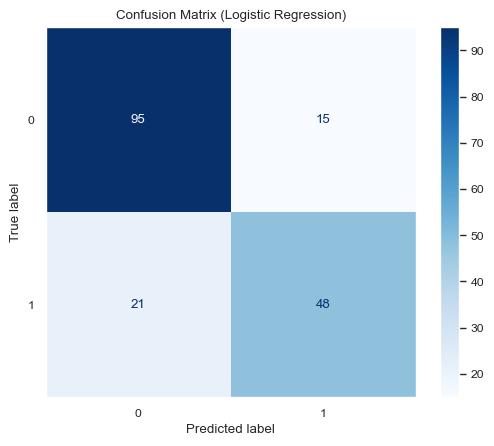

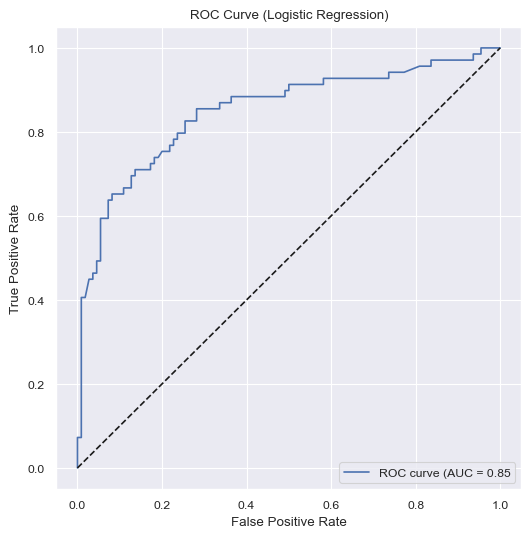

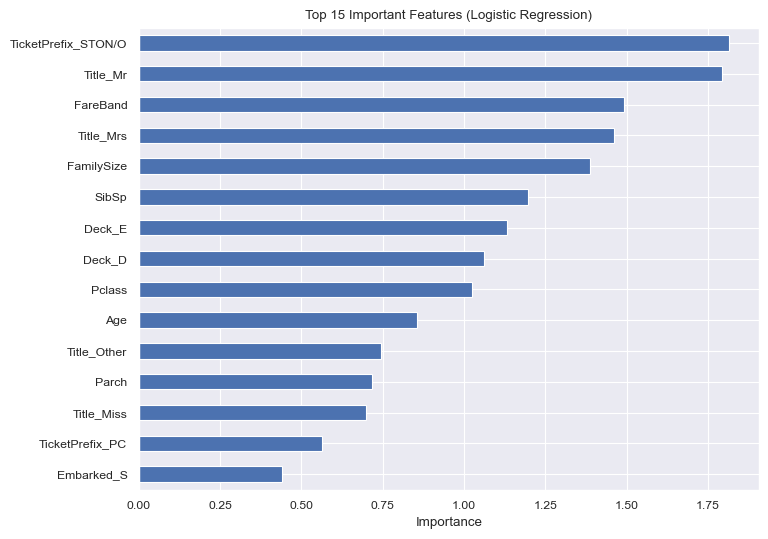

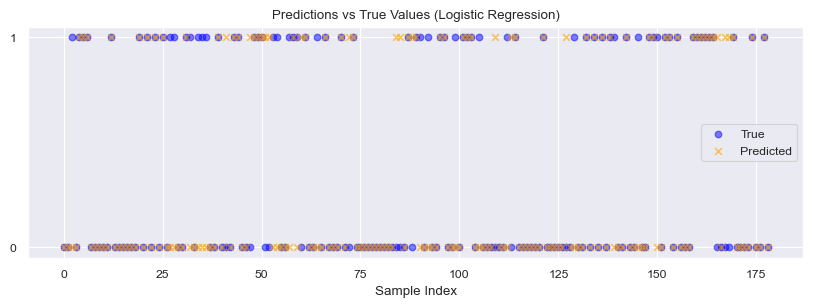

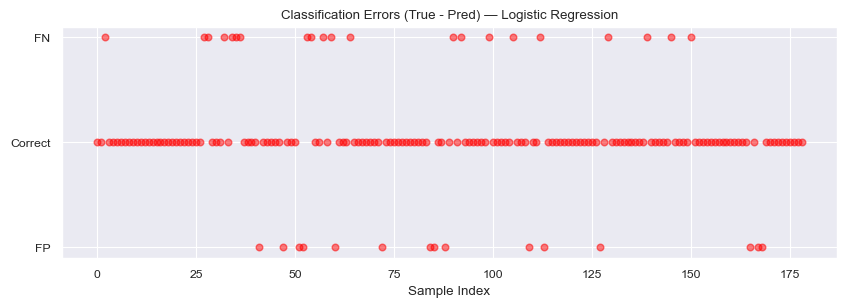

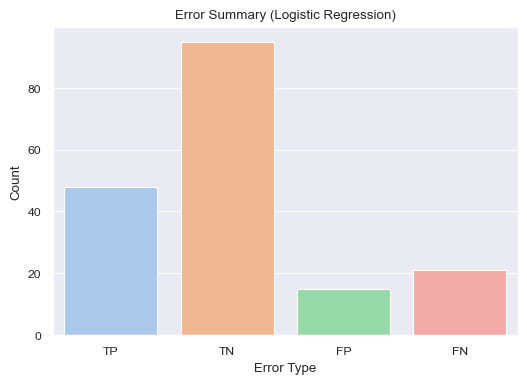

✅ Logged result for Logistic Regression


In [64]:
# Model
model_name = "Logistic Regression"
model_lr = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', random_state=RANDOM_STATE)

# Training
start = time.time()
model_lr.fit(X_train_scaled, y_train)
train_time = time.time() - start

# Prediction
y_pred = model_lr.predict(X_test_scaled)
y_proba = model_lr.predict_proba(X_test_scaled)[:, 1]

# Metrics
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba)
}

# Visualization
plot_confusion(y_test, y_pred, model_name)
plot_roc_curve(y_test, y_proba, model_name)
plot_feature_importance(model_lr, X_train_scaled, model_name=model_name)
plot_predictions_vs_truth(y_test, y_pred, model_name)
plot_prediction_errors(y_test, y_pred, model_name)
plot_error_summary(y_test, y_pred, model_name)

# Keeping results
results_df = log_model_result(results_df, model_name, model_lr.get_params(), metrics, train_time)

##### Model and Data interpratation (example for Logistic Regression)

This can also be used for other models

##### 🔄 Permutation Importance

We shuffle the values of each feature one at a time and measure how much the model performance drops.  
This helps us estimate **how important each feature is for accurate predictions**.

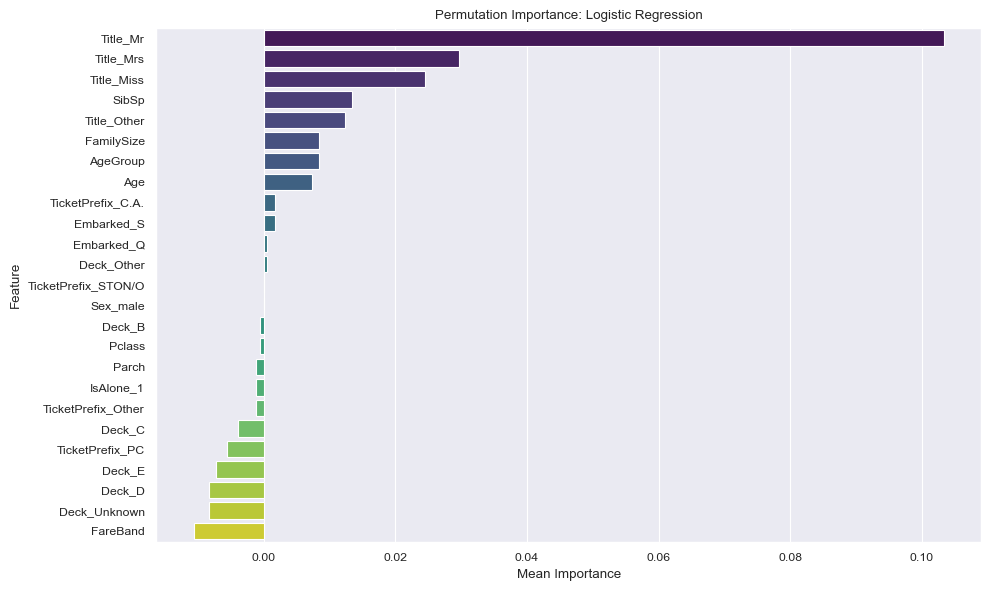

In [65]:
# If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?
importance_df = plot_permutation_importance(model_lr, X_test_scaled, y_test, feature_names=X_test_scaled.columns, model_name=model_name)

##### 📈 Partial Dependence Plot (PDP)

We fix all other features and vary one to see how the predicted survival probability changes.  
This plot shows the **average marginal effect of a feature on the model’s output**.

Plotting PDP for features: ['Title_Mr', 'Title_Mrs', 'Title_Miss', 'SibSp', 'Title_Other', 'FamilySize']
Model classes: [0 1]. Plotting PDP for: Class 1 (index 1)


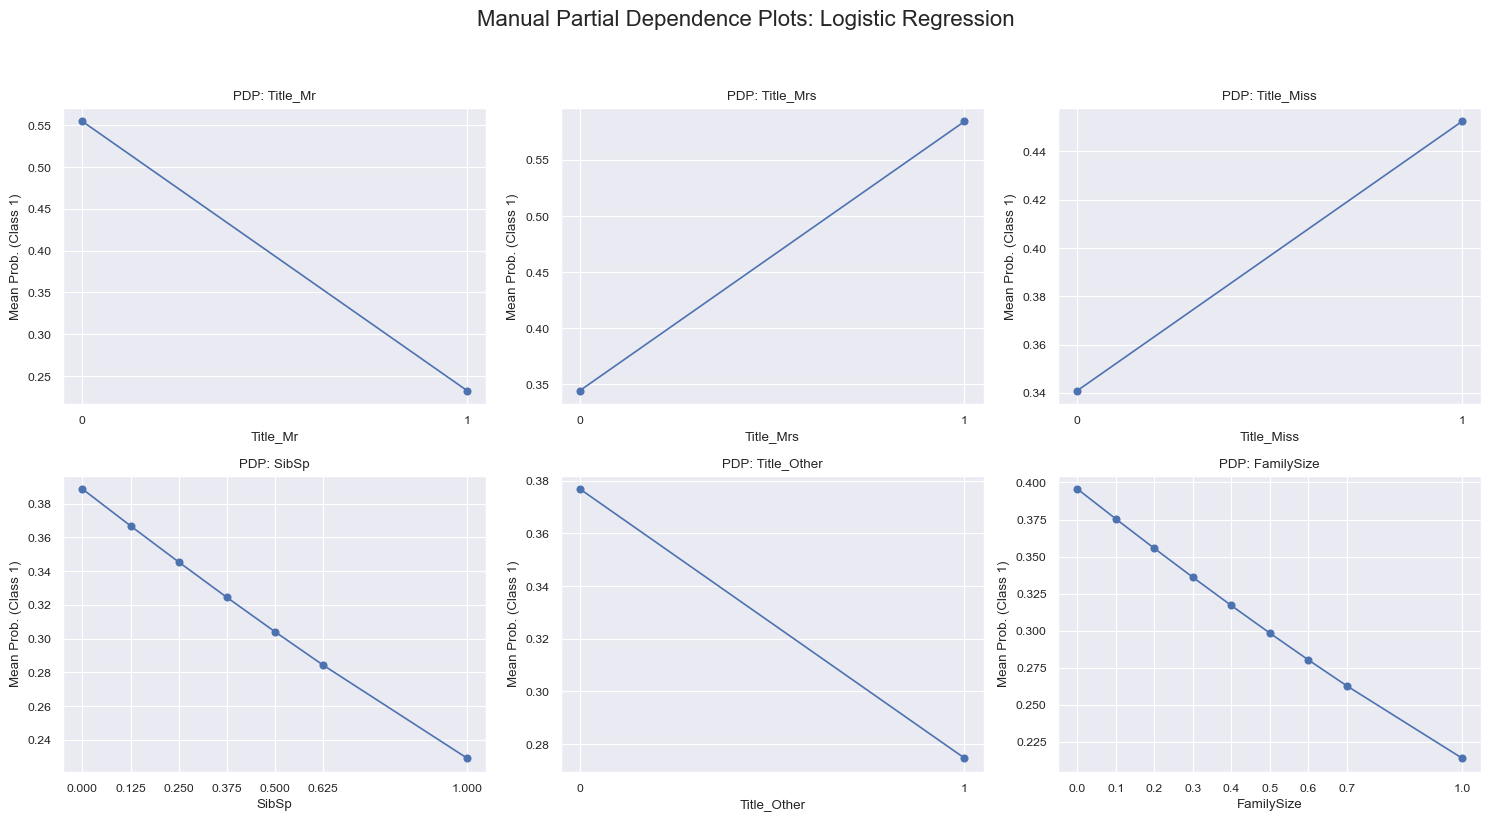

In [66]:
# If I fix all columns besides a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions if i change value from min to max? 
plot_partial_dependence_wrapper(
    model_lr,
    X_test_scaled,
    importance_df=importance_df,
    model_name=model_name,
    top_n=6
)

##### 🔍 SHAP Summary Plot

A global view of SHAP values across all features and samples.  
It shows **which features drive the predictions most**, how their values are distributed, and possible interactions (via color).

  0%|          | 0/179 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

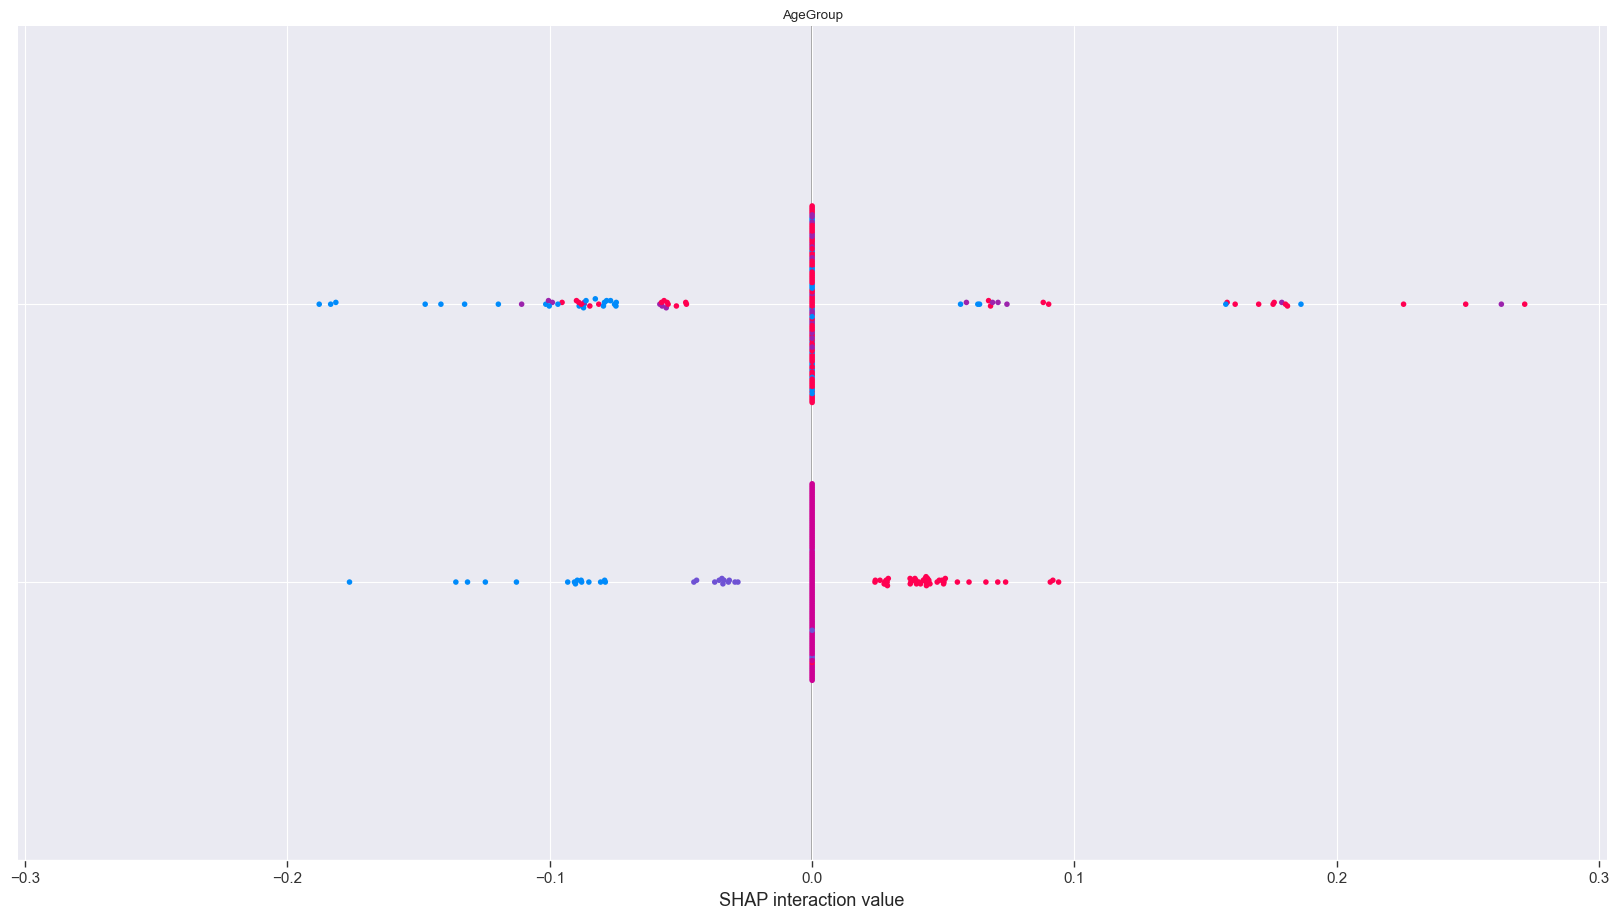

In [67]:
plot_shap_summary(model_lr, X_test_scaled)
# TO DO: add legend

##### 🎯 SHAP Dependence Plots (Top Features)

For each important feature, this plot shows how the SHAP value changes with feature value.  
Color represents **a second feature** that interacts most with the main one.

  0%|          | 0/179 [00:00<?, ?it/s]

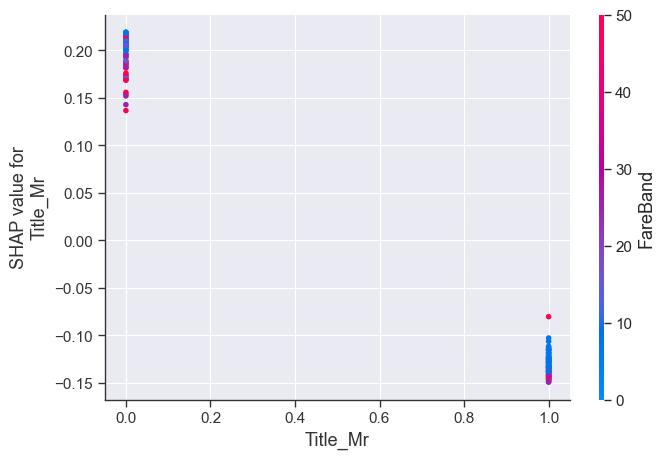

  0%|          | 0/179 [00:00<?, ?it/s]

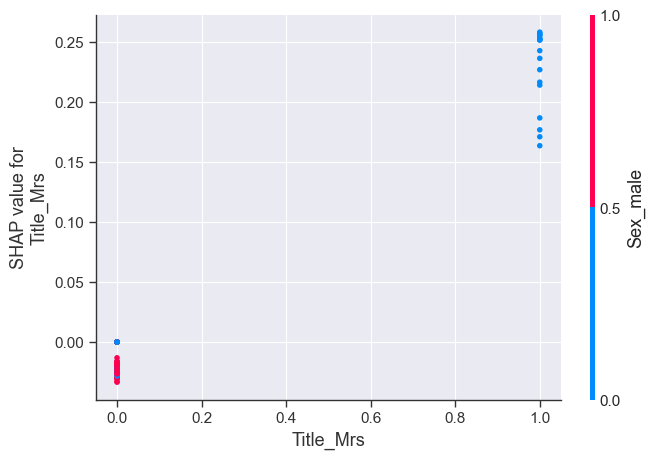

  0%|          | 0/179 [00:00<?, ?it/s]

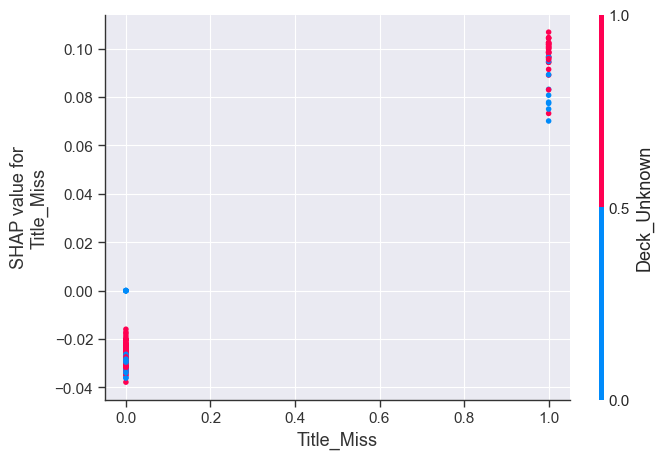

  0%|          | 0/179 [00:00<?, ?it/s]

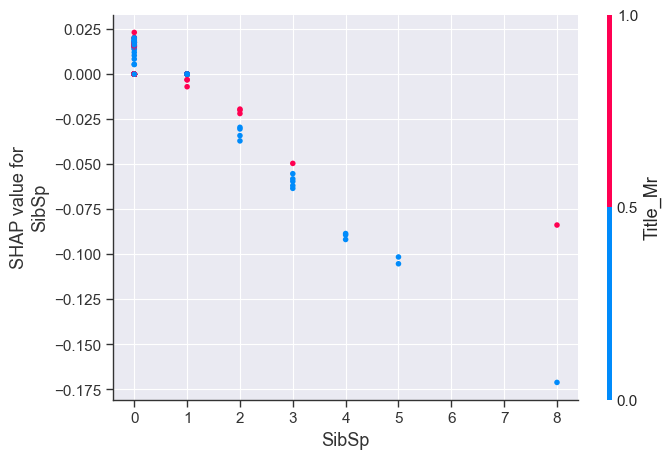

  0%|          | 0/179 [00:00<?, ?it/s]

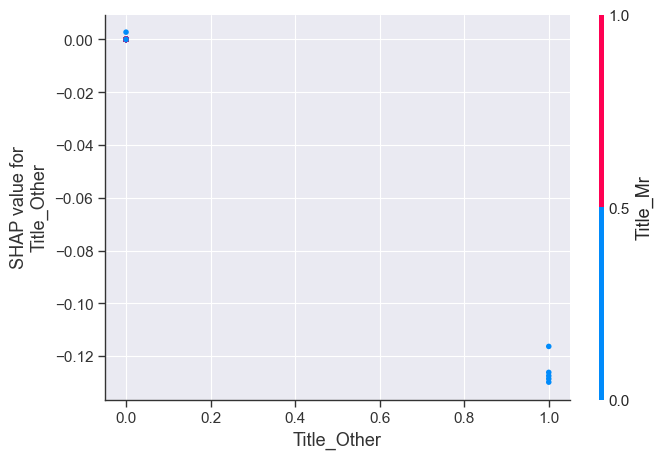

  0%|          | 0/179 [00:00<?, ?it/s]

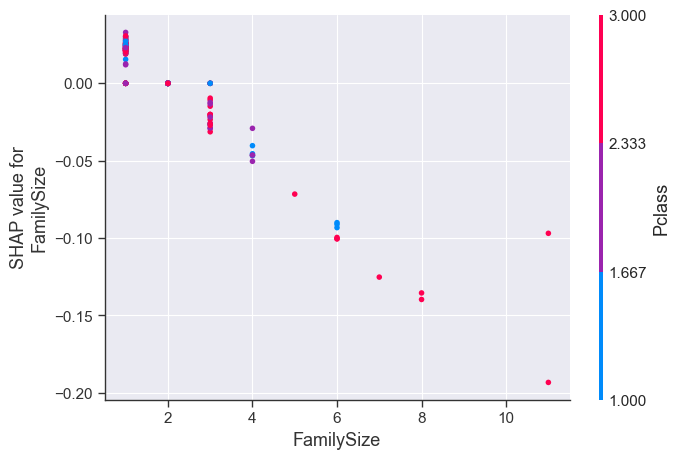

In [68]:
important_features = importance_df["Feature"].head(6)  # from permutation importance

for col in important_features:
    plot_shap_dependence(model_lr, X_test_scaled, X_test, feature=col)


##### 👤 SHAP Force Plot (Individual Prediction)

This plot shows how each feature contributed to a specific prediction.  
Red arrows push toward “did not survive” (0), blue toward “survived” (1).  
The title displays the **predicted survival probability**.

In [69]:
# find specific candidate
candidate = X_test[(X_test.Pclass == 1) & (X_test.Sex_male == 1)].head(1)
true_index = candidate.index[0]
X_test_scaled.index.get_loc(true_index)

7

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Embarked,Title,FamilySize,IsAlone,Deck,AgeGroup,Fare,FareBand,TicketPrefix
537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,S,Officer,1,1,B,adult,25.0,15.0,


🔢 Model logit (f(x)): -0.0699
✅ Predicted probability: 48.25%


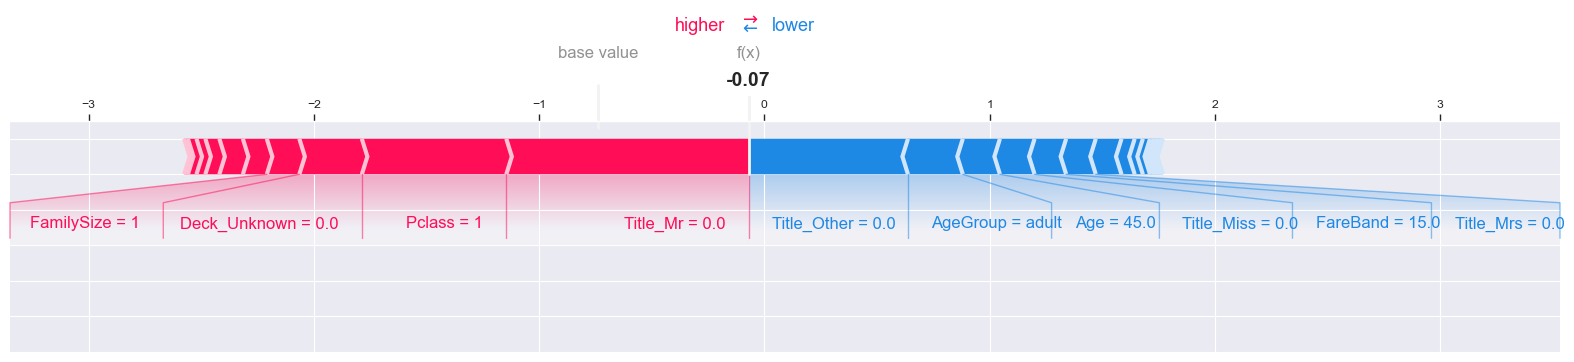

In [70]:
explain_passenger(
    index=7, # passenger index
    model=model_lr,
    X_scaled=X_test_scaled,
    X_original=X_test,
    df_original=df_original
)

#### K-Nearest Neighbors (KNN)

* `n_neighbors`: \[3, 5, 7, 11]
* `weights`: \['uniform', 'distance']
* `metric`: \['minkowski']

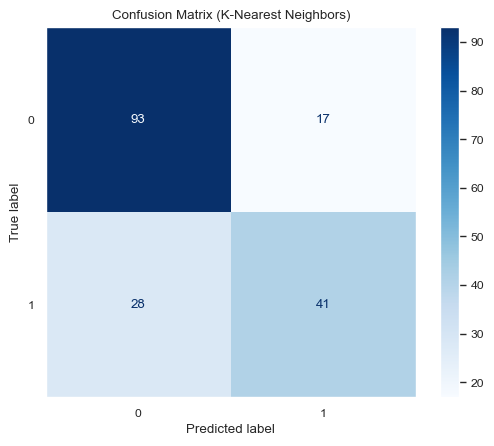

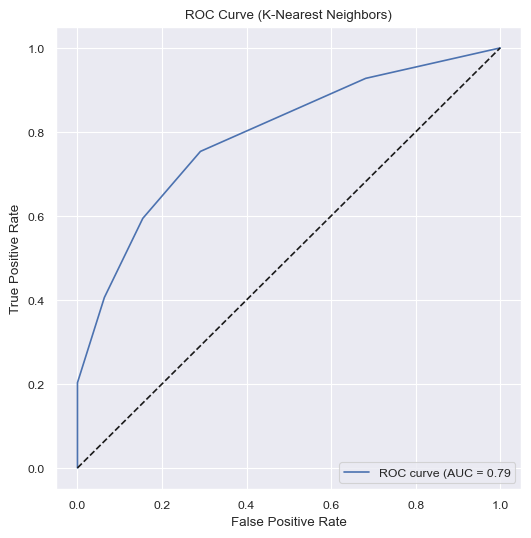

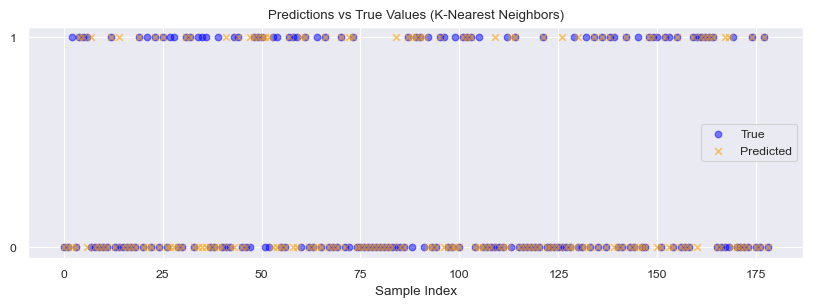

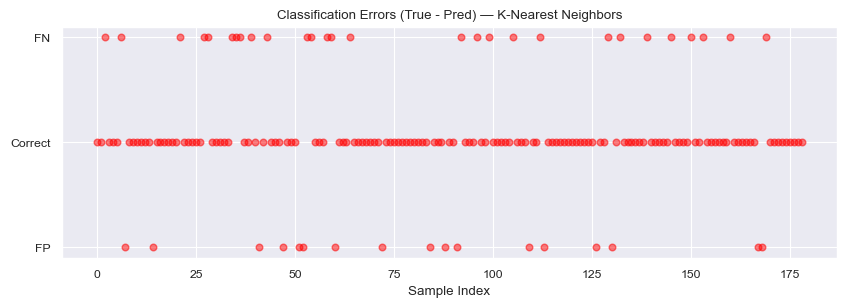

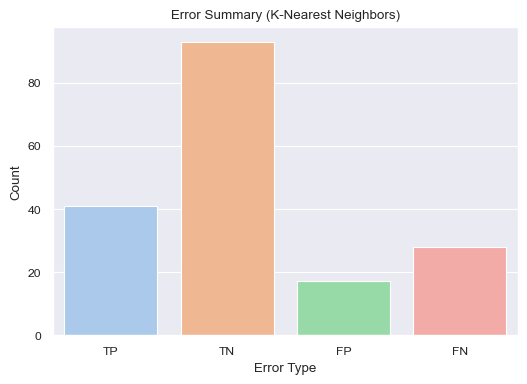

✅ Logged result for K-Nearest Neighbors


In [71]:
# Model
model_name = "K-Nearest Neighbors"
model_knn = KNeighborsClassifier(n_neighbors=5)

# Training
start = time.time()
model_knn.fit(X_train_scaled, y_train)
train_time = time.time() - start

# Prediction
y_pred = model_knn.predict(X_test_scaled)
y_proba = model_knn.predict_proba(X_test_scaled)[:, 1]

# Metrics
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba)
}

# Visualization
plot_confusion(y_test, y_pred, model_name)
plot_roc_curve(y_test, y_proba, model_name)

plot_predictions_vs_truth(y_test, y_pred, model_name)
plot_prediction_errors(y_test, y_pred, model_name)
plot_error_summary(y_test, y_pred, model_name)

# Keeping results
results_df = log_model_result(results_df, model_name, model_knn.get_params(), metrics, train_time)

#### Decision Tree

* `max_depth`: \[3, 5, 7, None]
* `min_samples_split`: \[2, 5, 10]
* `criterion`: \['gini', 'entropy']

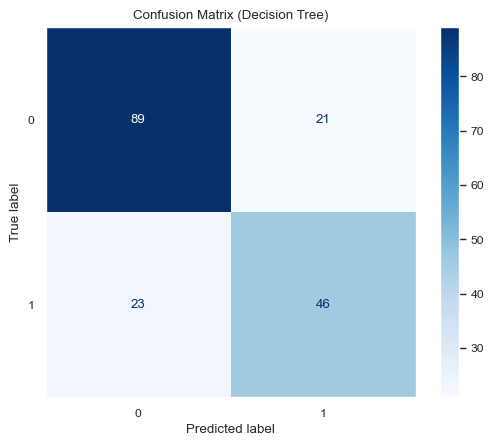

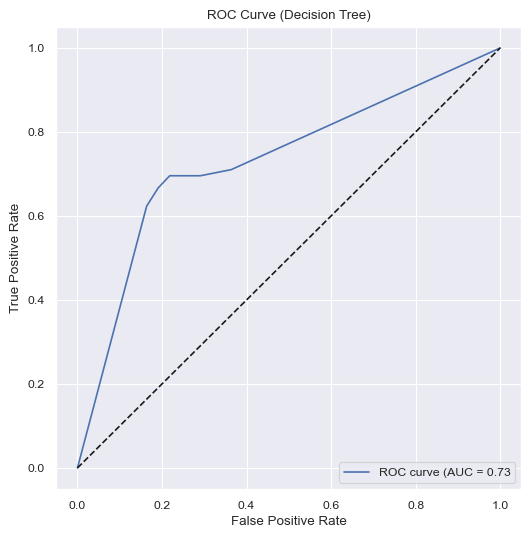

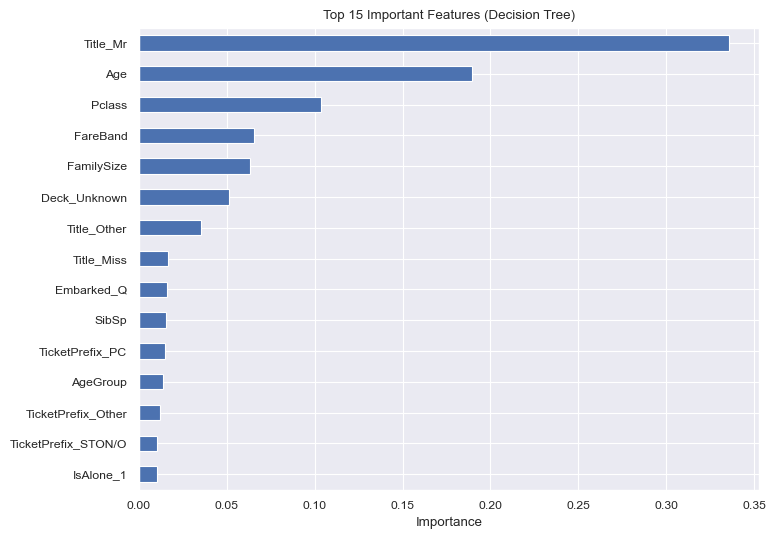

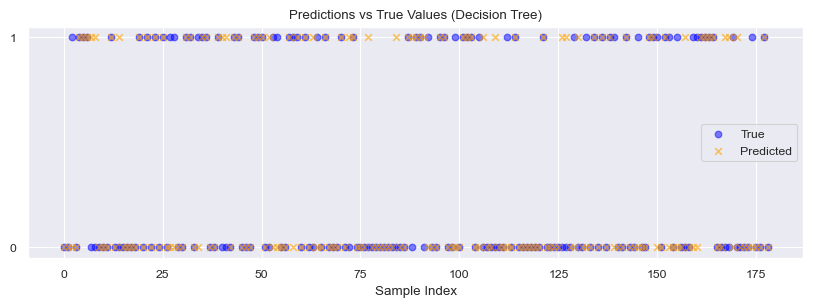

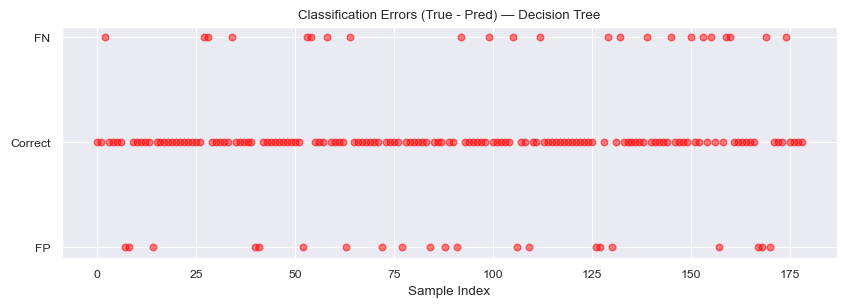

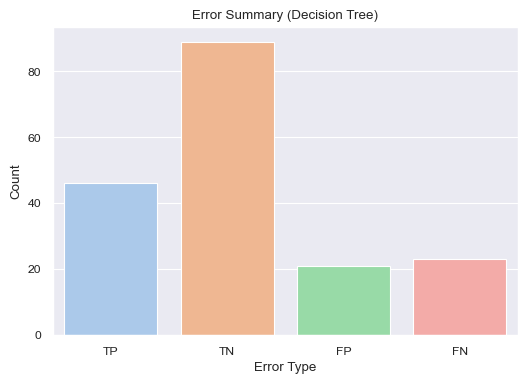

✅ Logged result for Decision Tree


In [72]:
# --- Decision Tree ---
model_name = "Decision Tree"

model_DecTree = DecisionTreeClassifier(random_state=RANDOM_STATE)

start = time.time()
model_DecTree.fit(X_train_tree, y_train)
train_time = time.time() - start

y_pred = model_DecTree.predict(X_test_tree)
y_proba = model_DecTree.predict_proba(X_test_tree)[:, 1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba),
}

# Visualization
plot_confusion(y_test, y_pred, model_name)
plot_roc_curve(y_test, y_proba, model_name)
plot_feature_importance(model_DecTree, X_train_scaled, model_name=model_name)
plot_predictions_vs_truth(y_test, y_pred, model_name)
plot_prediction_errors(y_test, y_pred, model_name)
plot_error_summary(y_test, y_pred, model_name)

# Keeping results
results_df = log_model_result(results_df, model_name, model_DecTree.get_params(), metrics, train_time)


In [73]:
# Tree visualization
# plot_decision_tree(model_DecTree, feature_names=X_train_tree.columns, class_names=["Not Survived", "Survived"], model_name=model_name)

export_tree_to_pdf(
    model=model_DecTree,
    feature_names=X_train_tree.columns,
    class_names=["Not Survived", "Survived"],
    output_path=RESULTS_PATH+"decision_tree",
    rename_map=rename_map,
    max_depth=6,
    show_graph=False
)

✅ Tree saved to: ././data/processed/decision_tree.pdf


#### Random Forest

* `n_estimators`: \[50, 100, 200]
* `max_depth`: \[None, 5, 10]
* `max_features`: \['sqrt', 'log2']

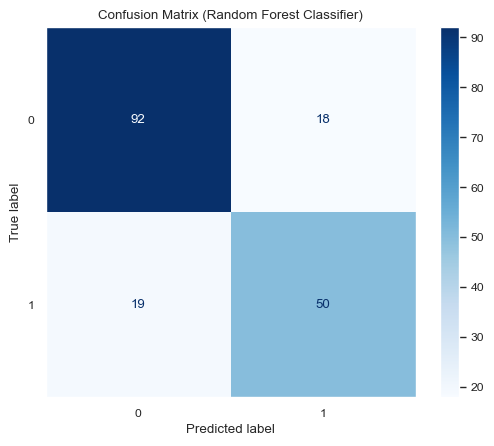

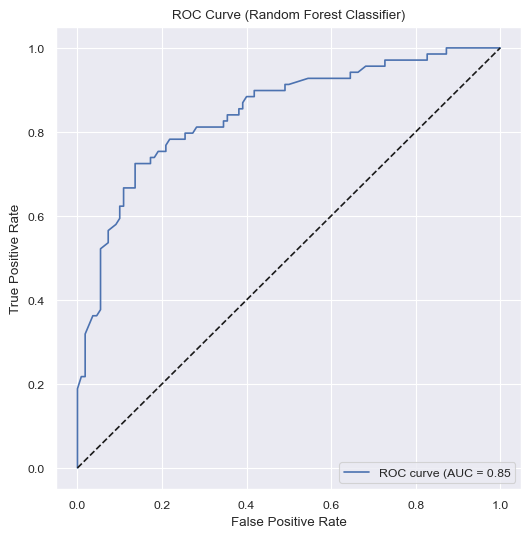

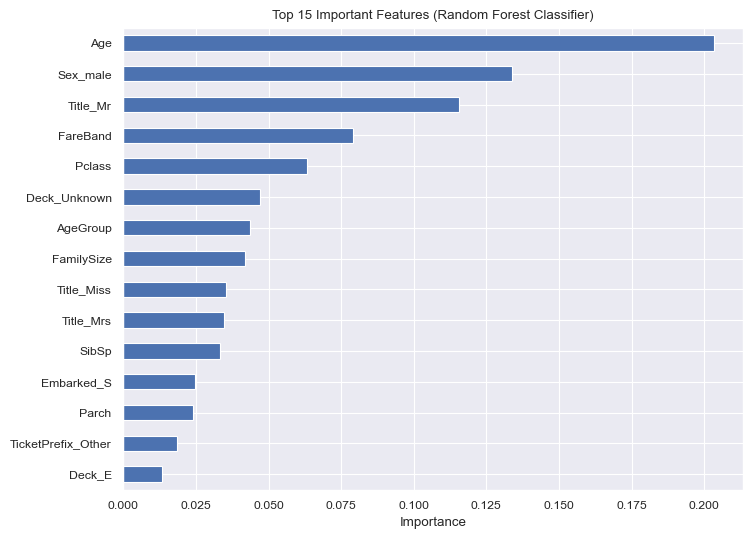

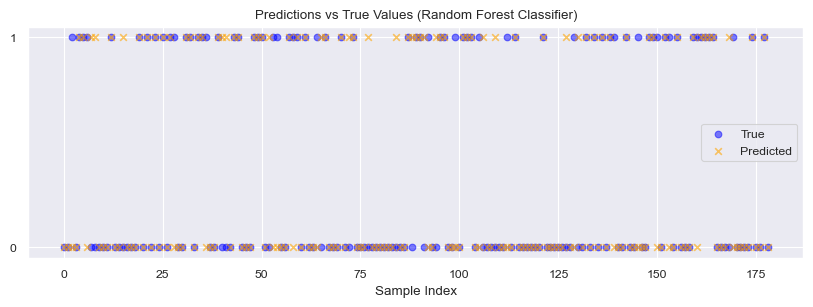

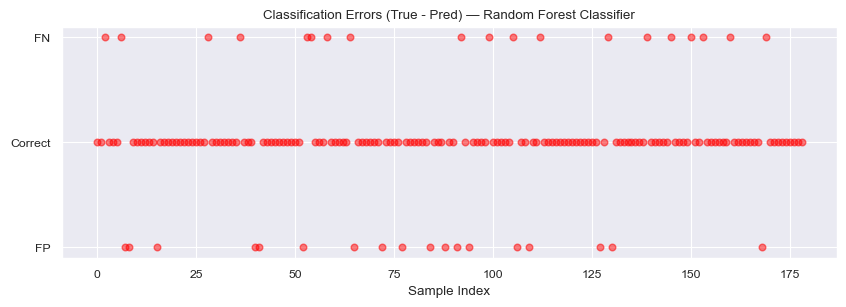

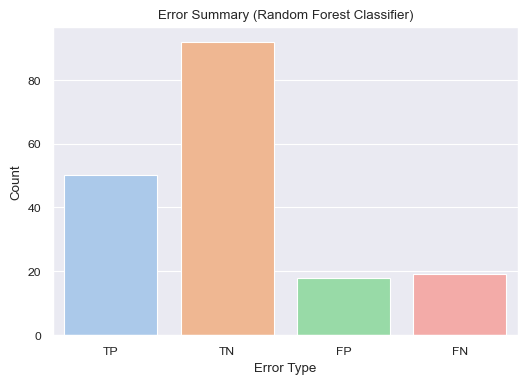

✅ Logged result for Random Forest Classifier


In [74]:
# --- Decision Tree ---
model_name = "Random Forest Classifier"

model_rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)

start = time.time()
model_rf_clf.fit(X_train_tree, y_train)
train_time = time.time() - start

y_pred = model_rf_clf.predict(X_test_tree)
y_proba = model_rf_clf.predict_proba(X_test_tree)[:, 1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba),
}

# Visualization
plot_confusion(y_test, y_pred, model_name)
plot_roc_curve(y_test, y_proba, model_name)
plot_feature_importance(model_rf_clf, X_train_scaled, model_name=model_name)
plot_predictions_vs_truth(y_test, y_pred, model_name)
plot_prediction_errors(y_test, y_pred, model_name)
plot_error_summary(y_test, y_pred, model_name)

# Keeping results
results_df = log_model_result(results_df, model_name, model_rf_clf.get_params(), metrics, train_time)

In [75]:
# Tree visualization
# plot_decision_tree(model_DecTree, feature_names=X_train_tree.columns, class_names=["Not Survived", "Survived"], model_name=model_name)

print (f"We have {len(model_rf_clf.estimators_)} tree estimators")

quantity_to_visualisation = 3

for i in range(quantity_to_visualisation):
    tree_estimator = model_rf_clf.estimators_[i]
    export_tree_to_pdf(
        model=tree_estimator,
        feature_names=X_train_tree.columns,
        class_names=["Not Survived", "Survived"],
        output_path=RESULTS_PATH+"random_forest_"+str(i),
        rename_map=rename_map,
        max_depth=6,
        show_graph=False
    )

We have 100 tree estimators
✅ Tree saved to: ././data/processed/random_forest_0.pdf
✅ Tree saved to: ././data/processed/random_forest_1.pdf
✅ Tree saved to: ././data/processed/random_forest_2.pdf


#### Gradient Boosting - XGBoost

* `learning_rate`: \[0.01, 0.1, 0.2]
* `n_estimators`: \[100, 200]
* `max_depth`: \[3, 5]

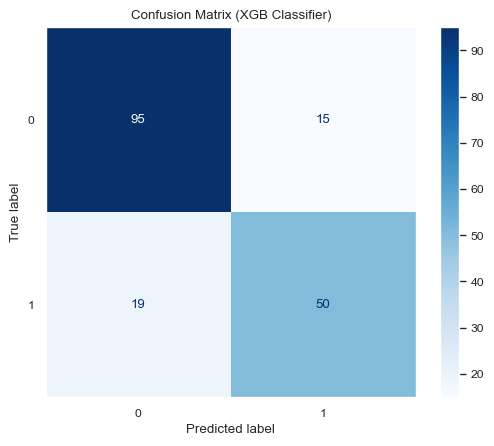

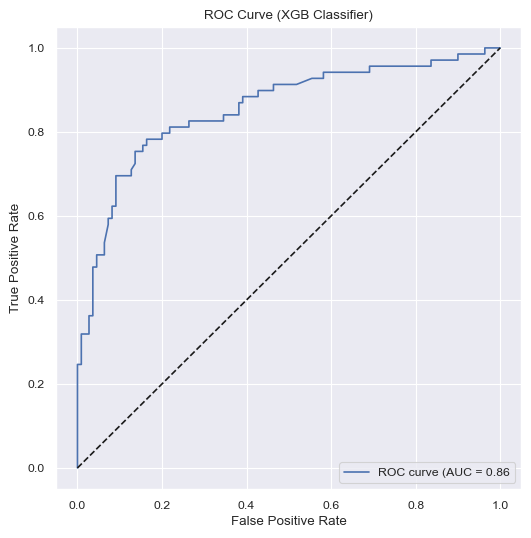

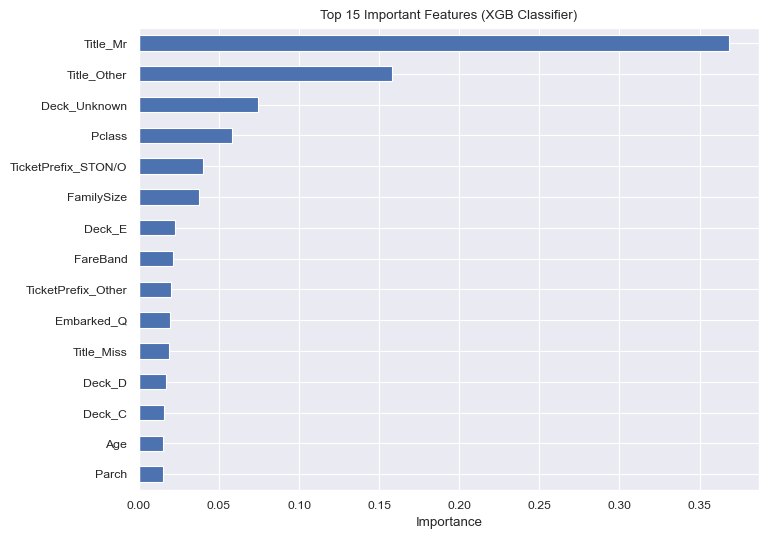

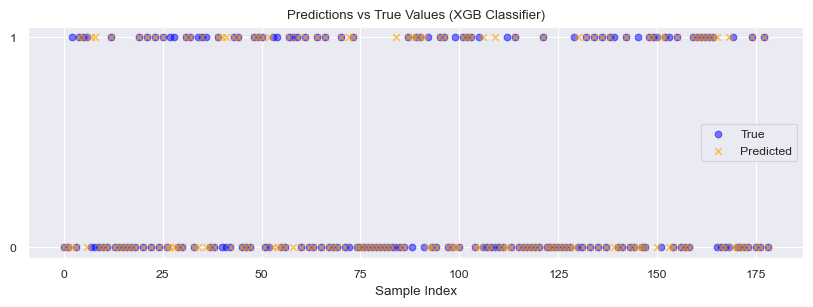

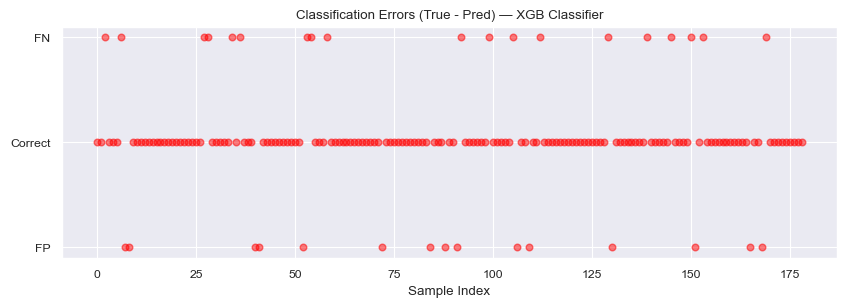

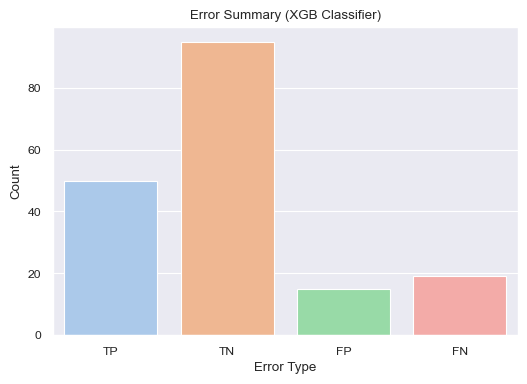

✅ Logged result for XGB Classifier


In [76]:
model_name = "XGB Classifier"

model_xgb = XGBClassifier(eval_metric='logloss', random_state=RANDOM_STATE)

start = time.time()
model_xgb.fit(X_train_tree, y_train)
train_time = time.time() - start

y_pred = model_xgb.predict(X_test_tree)
y_proba = model_xgb.predict_proba(X_test_tree)[:, 1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba),
}

# Visualization
plot_confusion(y_test, y_pred, model_name)
plot_roc_curve(y_test, y_proba, model_name)
plot_feature_importance(model_xgb, X_train_scaled, model_name=model_name)
plot_predictions_vs_truth(y_test, y_pred, model_name)
plot_prediction_errors(y_test, y_pred, model_name)
plot_error_summary(y_test, y_pred, model_name)

# Keeping results
results_df = log_model_result(results_df, model_name, model_xgb.get_params(), metrics, train_time)

#### Gradient Boosting - LightGBM

* `learning_rate`: \[0.01, 0.1, 0.2]
* `n_estimators`: \[100, 200]
* `max_depth`: \[3, 5]

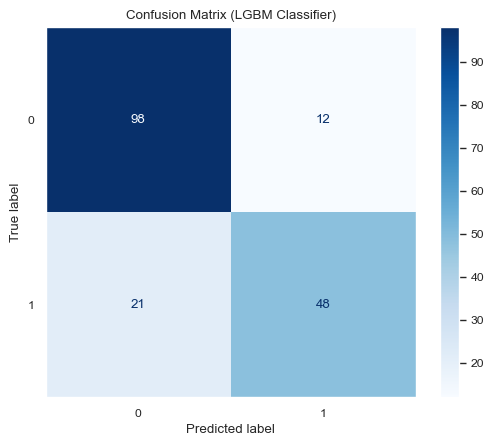

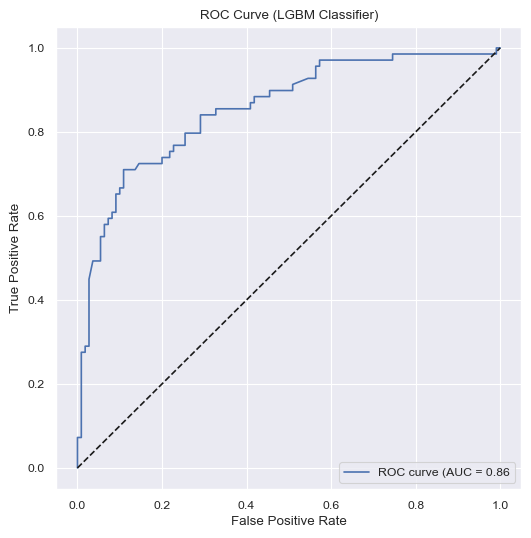

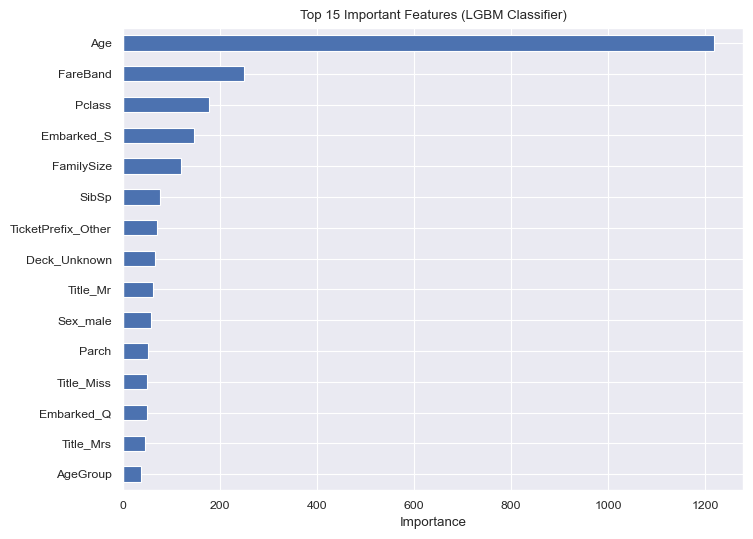

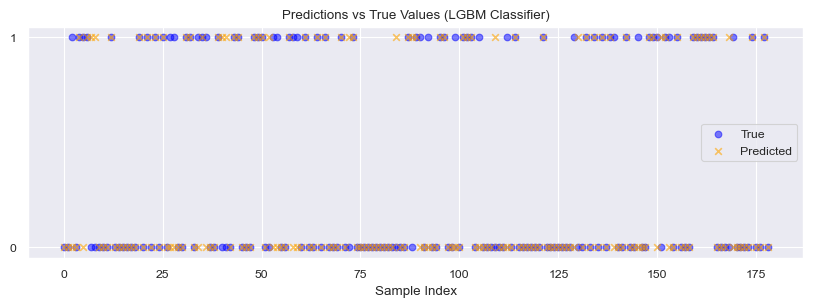

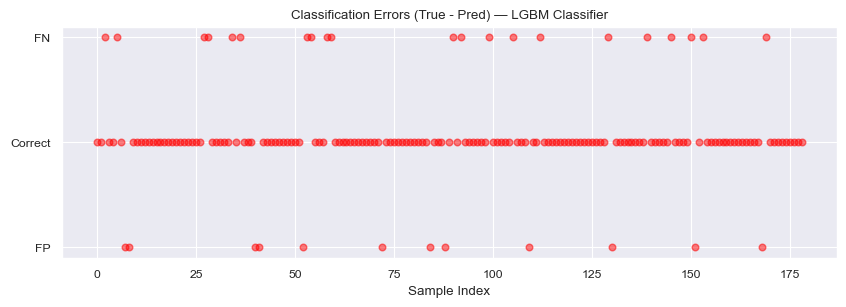

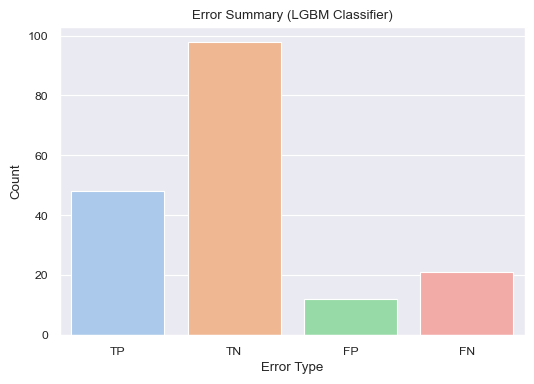

✅ Logged result for LGBM Classifier


In [78]:
model_name = "LGBM Classifier"

model_lgbm = LGBMClassifier(random_state=RANDOM_STATE, verbosity=-1)

start = time.time()
model_lgbm.fit(X_train_tree, y_train)
train_time = time.time() - start

y_pred = model_lgbm.predict(X_test_tree)
y_proba = model_lgbm.predict_proba(X_test_tree)[:, 1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba),
}

# Visualization
plot_confusion(y_test, y_pred, model_name)
plot_roc_curve(y_test, y_proba, model_name)
plot_feature_importance(model_lgbm, X_train_scaled, model_name=model_name)
plot_predictions_vs_truth(y_test, y_pred, model_name)
plot_prediction_errors(y_test, y_pred, model_name)
plot_error_summary(y_test, y_pred, model_name)

# Keeping results
results_df = log_model_result(results_df, model_name, model_lgbm.get_params(), metrics, train_time)

#### Support Vector Machine (SVM)

* `C`: \[0.1, 1, 10]
* `kernel`: \['linear', 'rbf']
* `gamma`: \['scale', 'auto']

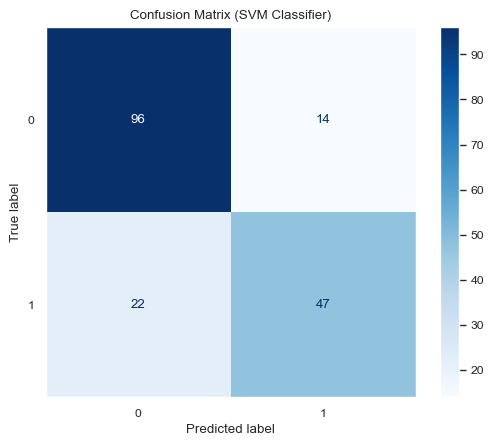

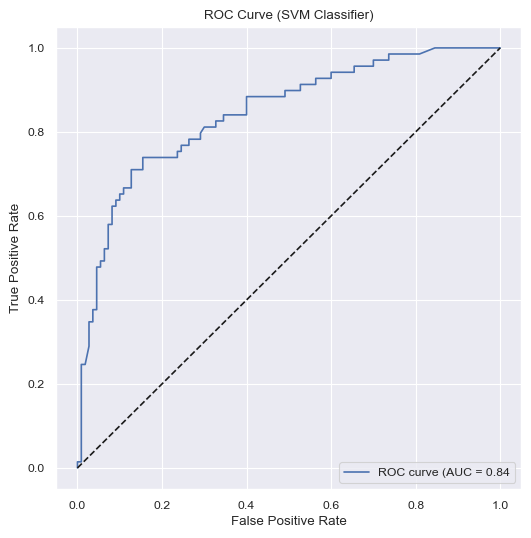

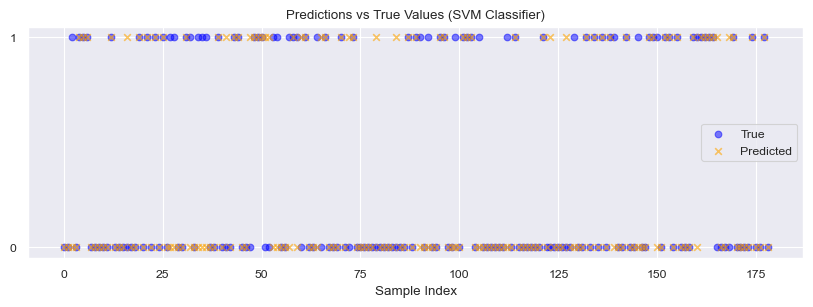

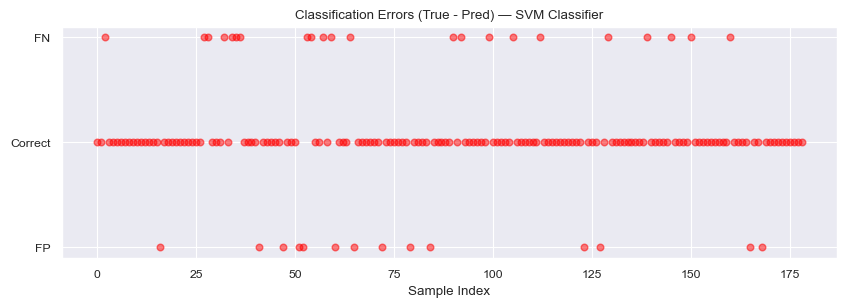

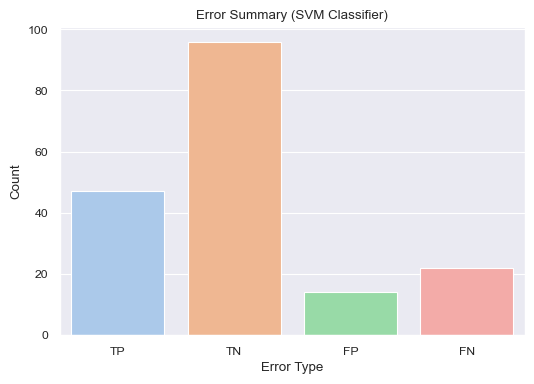

✅ Logged result for SVM Classifier


In [79]:
model_name = "SVM Classifier"

model_svm = SVC(probability=True, kernel='rbf', random_state=RANDOM_STATE)

start = time.time()
model_svm.fit(X_train_scaled, y_train)
train_time = time.time() - start

y_pred = model_svm.predict(X_test_scaled)
y_proba = model_svm.predict_proba(X_test_scaled)[:, 1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba),
}

# Visualization
plot_confusion(y_test, y_pred, model_name)
plot_roc_curve(y_test, y_proba, model_name)
plot_predictions_vs_truth(y_test, y_pred, model_name)
plot_prediction_errors(y_test, y_pred, model_name)
plot_error_summary(y_test, y_pred, model_name)

# Save results
results_df = log_model_result(results_df, model_name, model_svm.get_params(), metrics, train_time)


#### Multi-Layer Perceptron (Neural Network)

A simple feed-forward neural network with one or more hidden layers.  
It uses backpropagation for training and supports nonlinear decision boundaries.

- `hidden_layer_sizes`: (64, 32) — two hidden layers with 64 and 32 neurons
- `activation`: 'relu' — rectified linear unit for nonlinearity
- `solver`: 'adam' — stochastic optimizer
- `max_iter`: 500 — maximum training iterations
- ⚠️ Requires scaled input data


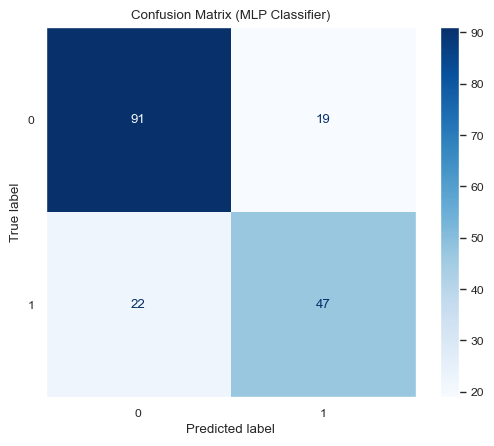

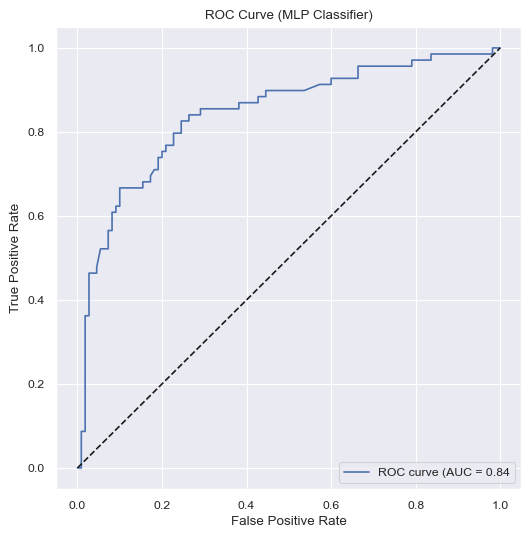

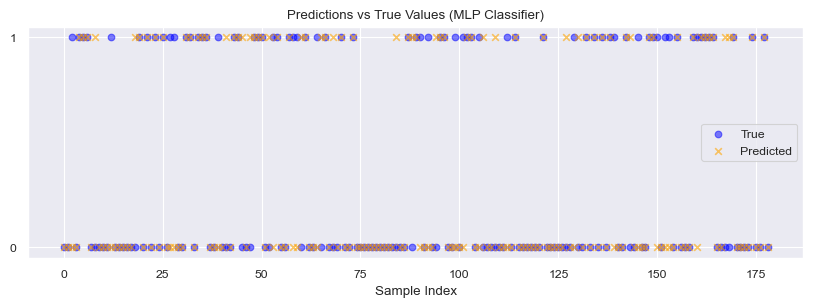

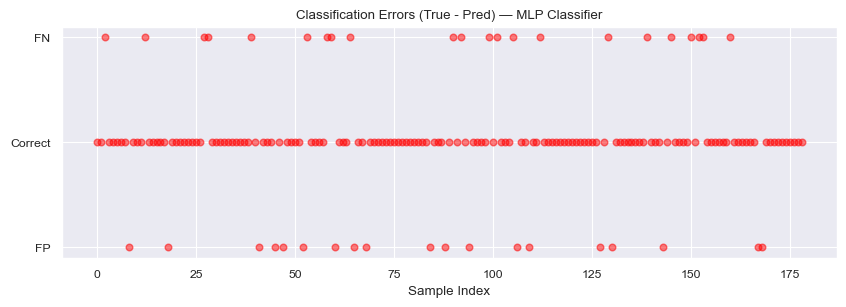

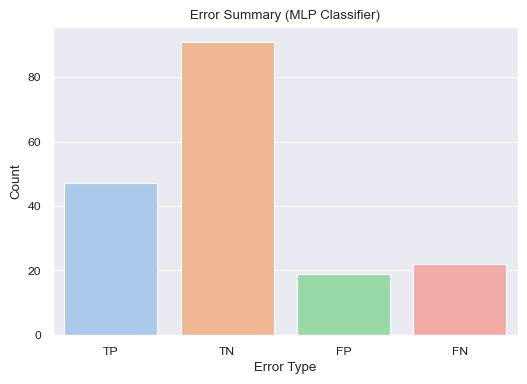

✅ Logged result for MLP Classifier


In [80]:
model_name = "MLP Classifier"

model_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=RANDOM_STATE)

start = time.time()
model_mlp.fit(X_train_tree, y_train)
train_time = time.time() - start

y_pred = model_mlp.predict(X_test_tree)
y_proba = model_mlp.predict_proba(X_test_tree)[:, 1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba),
}

# Visualization
plot_confusion(y_test, y_pred, model_name)
plot_roc_curve(y_test, y_proba, model_name)
# no feature importance
plot_predictions_vs_truth(y_test, y_pred, model_name)
plot_prediction_errors(y_test, y_pred, model_name)
plot_error_summary(y_test, y_pred, model_name)

# Keeping results
results_df = log_model_result(results_df, model_name, model_mlp.get_params(), metrics, train_time)

### Model comparison summary
- Tabular comparison of key metrics

In [81]:
display_df(results_df)

model_name,params,accuracy,precision,recall,f1,roc_auc,training_time,notes
Logistic Regression,"{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}",0.798883,0.761905,0.695652,0.727273,0.849012,0.003418,
K-Nearest Neighbors,"{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",0.748603,0.706897,0.594203,0.645669,0.791963,0.001518,
Decision Tree,"{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}",0.754190,0.686567,0.666667,0.676471,0.733004,0.003022,
Random Forest Classifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}",0.793296,0.735294,0.724638,0.729927,0.845916,0.079412,
Random Forest Classifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}",0.793296,0.735294,0.724638,0.729927,0.845916,0.079069,
Logistic Regression,"{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}",0.798883,0.761905,0.695652,0.727273,0.849012,0.002001,
K-Nearest Neighbors,"{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",0.748603,0.706897,0.594203,0.645669,0.791963,0.001007,
Decision Tree,"{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}",0.754190,0.686567,0.666667,0.676471,0.733004,0.002007,
Random Forest Classifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}",0.793296,0.735294,0.724638,0.729927,0.845916,0.075866,
XGB Classifier,"{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': Non

model_name,f1,roc_auc
XGB Classifier,0.746269,0.855599
LGBM Classifier,0.744186,0.855204
LGBM Classifier,0.744186,0.855204
Random Forest Classifier,0.729927,0.845916
Random Forest Classifier,0.729927,0.845916
Random Forest Classifier,0.729927,0.845916
Logistic Regression,0.727273,0.849012
Logistic Regression,0.727273,0.849012
SVM Classifier,0.723077,0.844532
MLP Classifier,0.696296,0.843742


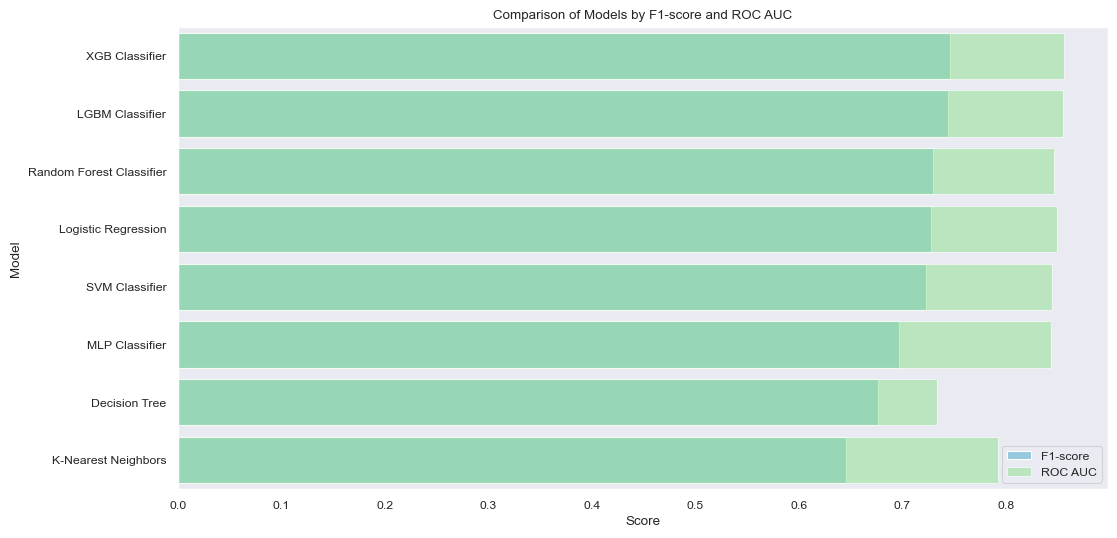

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

sorted_df = results_df[["model_name","f1","roc_auc"]].sort_values(by=["f1", "roc_auc"], ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=sorted_df, x="f1", y="model_name", color="skyblue", label="F1-score")
sns.barplot(data=sorted_df, x="roc_auc", y="model_name", color="lightgreen", label="ROC AUC", alpha=0.6)
plt.xlabel("Score")
plt.ylabel("Model")
plt.title("Comparison of Models by F1-score and ROC AUC")
plt.legend()
plt.grid(axis='x')

display_df(sorted_df)
plt.show()

##### Model Comparison Summary

This table summarizes the performance of different classification models using key evaluation metrics:

- **F1-score**: balances precision and recall — suitable for imbalanced data.
- **ROC AUC**: measures overall ranking quality — useful for binary classification.
- **Training time**: important for scalability and deployment.

##### Top Performing Models

- **XGB Classifier**  
  - F1-score: **0.75**  
  - ROC AUC: **0.86**  
  - Strong candidate for further optimization.

- **Random Forest & LGBM Classifiers**  
  - Very close to XGB in both F1 and ROC AUC.  
  - Slightly faster to train.  

- **MLP Classifier**  
  - Competitive performance (F1 ≈ 0.74, ROC AUC ≈ 0.84)  
  - Worth considering as a neural-network baseline.

##### Lower Performing Models

- **K-Nearest Neighbors** and **Decision Tree** underperformed in all key metrics.  
  - These models are not selected for further tuning.

##### Next Steps

- Select the top 2–3 models (**XGB**, **LGBM**, **MLP**) for **hyperparameter tuning**.
- Use cross-validation to refine model performance.
- Track performance gains across different configurations.


### Cross-validation & Hyperparameter Tuning
- Use cross-validation (e.g., StratifiedKFold) to better estimate model performance.
- Perform grid/random search for hyperparameter tuning on the top-performing models (XGB, RandomForest, MLP).
- Log performance metrics (e.g., F1-score, ROC AUC) across different configurations.
- Store results in a separate DataFrame for easy comparison and analysis.

We aim to select the best configuration for each model and understand how tuning affects performance stability.

In [83]:
# CV and hyperparameters tuning results DataFrame to accumulate model results
cv_results_df = pd.DataFrame(columns=[
    "model_name", "params", "accuracy_cv", "f1_cv", "roc_auc_cv", "accuracy_test", "f1_test", "roc_auc_test", "training_time", "notes"
])

##### MLP

In [92]:
param_grid_mlp = {
    "hidden_layer_sizes": [(64,), (64, 32)],
    "activation": ["relu"],
    "alpha": [0.0001, 0.001],
    "max_iter": [1000]
}

model_name = "MLP (GridSearch)"
model_mlp = MLPClassifier(random_state=RANDOM_STATE)

cv_results_df, best_mlp, mlp_grid = evaluate_model_cv(
    model=model_mlp,
    param_grid=param_grid_mlp,
    X_train=X_train_tree,
    y_train=y_train,
    X_test=X_test_tree,
    y_test=y_test,
    model_name=model_name,
    results_df=cv_results_df,
    notes="Initial tuning",
    scoring="f1"
)

- **MLP Classifier**
  - Try deeper and wider architectures (e.g., `(64, 32)`, `(128, 64)`)
  - Test both `relu` and `tanh` activations
  - Adjust `alpha` (L2 regularization strength) and initial learning rate


In [93]:
param_grid_mlp = {
    "hidden_layer_sizes": [(32,), (64,), (128,), (64, 32), (128, 64)],
    "activation": ["relu", "tanh"],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate_init": [0.001, 0.01], 
    "max_iter": [500, 1000],
}

model_name = "MLP (GridSearch)"
model_mlp = MLPClassifier(random_state=RANDOM_STATE)

cv_results_df, best_mlp, mlp_grid = evaluate_model_cv(
    model=model_mlp,
    param_grid=param_grid_mlp,
    X_train=X_train_tree,
    y_train=y_train,
    X_test=X_test_tree,
    y_test=y_test,
    model_name=model_name,
    results_df=cv_results_df,
    notes="Ext_1",
    scoring="f1"
)

##### XGBoost

In [94]:
param_grid_xgb = {
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
}

model_name = "XGB (GridSearch)"
model_xgb = XGBClassifier(eval_metric="logloss", random_state=RANDOM_STATE)

cv_results_df, best_xgb, xgb_grid = evaluate_model_cv(
    model=model_xgb,
    param_grid=param_grid_xgb,
    X_train=X_train_tree,
    y_train=y_train,
    X_test=X_test_tree,
    y_test=y_test,
    model_name=model_name,
    results_df=cv_results_df,
    notes="Initial tuning",
    scoring="f1"
)


- **XGBoost Classifier**
  - Extend `learning_rate` range to include smaller and larger steps
  - Increase `n_estimators` and `max_depth`
  - Tune `subsample` and `colsample_bytree` to reduce variance

In [95]:
param_grid_xgb = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],           
    "colsample_bytree": [0.8, 1.0],   
}
model_name = "XGB (GridSearch)"
model_xgb = XGBClassifier(eval_metric="logloss", random_state=RANDOM_STATE)

cv_results_df, best_xgb, xgb_grid = evaluate_model_cv(
    model=model_xgb,
    param_grid=param_grid_xgb,
    X_train=X_train_tree,
    y_train=y_train,
    X_test=X_test_tree,
    y_test=y_test,
    model_name=model_name,
    results_df=cv_results_df,
    notes="Ext_1",
    scoring="f1"
)


#### Random Forest

In [96]:
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

model_name = "Random Forest (GridSearch)"
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

cv_results_df, best_rf, rf_grid = evaluate_model_cv(
    model=model_rf,
    param_grid=param_grid_rf,
    X_train=X_train_tree,
    y_train=y_train,
    X_test=X_test_tree,
    y_test=y_test,
    model_name=model_name,
    results_df=cv_results_df,
    notes="Initial tuning",
    scoring="f1"
)

- **Random Forest Classifier**
  - Add more trees (`n_estimators`) and deeper trees (`max_depth`)
  - Vary `min_samples_split` and `min_samples_leaf` to control overfitting
  - Try both bootstrapped and non-bootstrapped samples

In [97]:
param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
}


model_name = "Random Forest (GridSearch)"
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

cv_results_df, best_rf, rf_grid = evaluate_model_cv(
    model=model_rf,
    param_grid=param_grid_rf,
    X_train=X_train_tree,
    y_train=y_train,
    X_test=X_test_tree,
    y_test=y_test,
    model_name=model_name,
    results_df=cv_results_df,
    notes="Ext_1",
    scoring="f1"
)

In [98]:
display_df(cv_results_df)

model_name,params,accuracy_cv,f1_cv,roc_auc_cv,accuracy_test,f1_test,roc_auc_test,training_time,notes
MLP (GridSearch),"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64,), 'max_iter': 1000}",None,0.758020,None,0.804469,0.728682,0.846245,2.225520,Initial tuning
MLP (GridSearch),"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.01, 'max_iter': 500}",None,0.765423,None,0.798883,0.714286,0.851910,18.246960,Ext_1
XGB (GridSearch),"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}",None,0.774696,None,0.810056,0.738462,0.859486,2.669601,Initial tuning
XGB (GridSearch),"{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}",None,0.774696,None,0.810056,0.738462,0.859486,2.140005,Ext_1
Random Forest (GridSearch),"{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}",None,0.766571,None,0.815642,0.751880,0.844071,1.205715,Initial tuning
Random Forest (GridSearch),"{'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}",None,0.767198,None,0.810056,0.742424,0.837549,9.819904,Ext_1
MLP (GridSearch),"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64,), 'max_iter': 1000}",None,0.758020,None,0.804469,0.728682,0.846245,1.363979,Initial tuning
MLP (GridSearch),"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.01, 'max_iter': 500}",None,0.765423,None,0.798883,0.714286,0.851910,15.920432,Ext_1
XGB (GridSearch),"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}",None,0.774696,None,0.810056,0.738462,0.859486,0.196151,Initial tuning
XGB (GridSearch),"{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}",None,0.774696,None,0.810056,0.738462,0.859486,1.959494,Ext_1


model_name,f1_cv,accuracy_test,f1_test,roc_auc_test,notes,model_ext
XGB (GridSearch),0.774696,0.810056,0.738462,0.859486,Initial tuning,XGB (GridSearch) (Initial tuning)
XGB (GridSearch),0.774696,0.810056,0.738462,0.859486,Ext_1,XGB (GridSearch) (Ext_1)
XGB (GridSearch),0.774696,0.810056,0.738462,0.859486,Initial tuning,XGB (GridSearch) (Initial tuning)
XGB (GridSearch),0.774696,0.810056,0.738462,0.859486,Ext_1,XGB (GridSearch) (Ext_1)
Random Forest (GridSearch),0.767198,0.810056,0.742424,0.837549,Ext_1,Random Forest (GridSearch) (Ext_1)
Random Forest (GridSearch),0.767198,0.810056,0.742424,0.837549,Ext_1,Random Forest (GridSearch) (Ext_1)
Random Forest (GridSearch),0.766571,0.815642,0.751880,0.844071,Initial tuning,Random Forest (GridSearch) (Initial tuning)
Random Forest (GridSearch),0.766571,0.815642,0.751880,0.844071,Initial tuning,Random Forest (GridSearch) (Initial tuning)
MLP (GridSearch),0.765423,0.798883,0.714286,0.851910,Ext_1,MLP (GridSearch) (Ext_1)
MLP (GridSearch),0.765423,0.798883,0.714286,0.851910,Ext_1,MLP (GridSearch) (Ext_1)


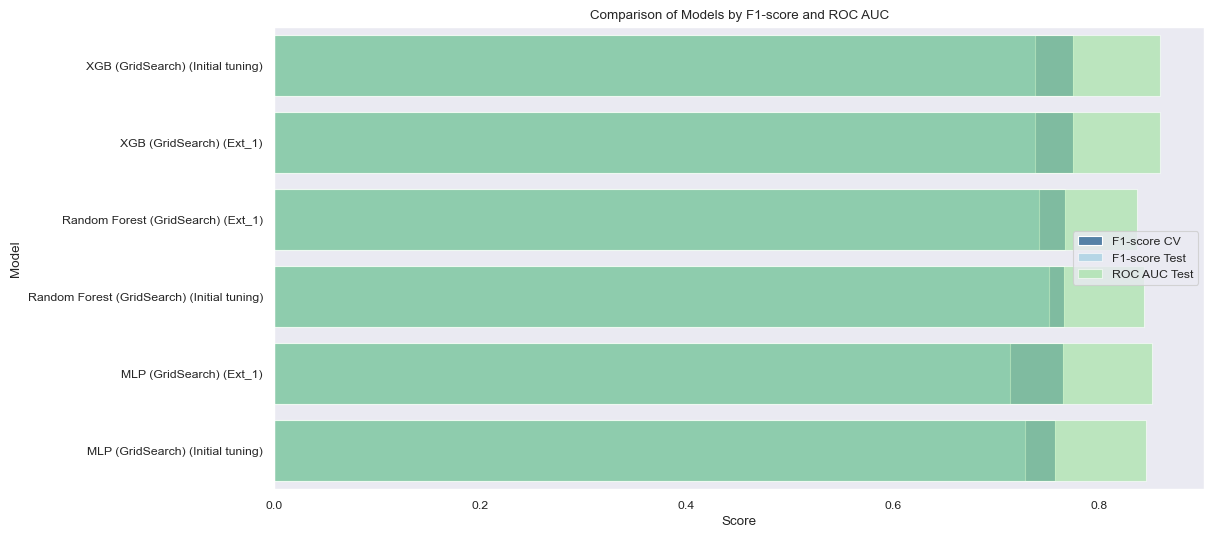

In [99]:
sorted_df = cv_results_df[["model_name","f1_cv","accuracy_test","f1_test","roc_auc_test","notes"]].sort_values(by=["f1_cv", "f1_test"], ascending=False).reset_index(drop=True)
sorted_df["model_ext"] =sorted_df.model_name+" ("+sorted_df.notes+")"

plt.figure(figsize=(12, 6))
sns.barplot(data=sorted_df, x="f1_cv", y="model_ext", color="steelblue", label="F1-score CV")
sns.barplot(data=sorted_df, x="f1_test", y="model_ext", color="skyblue", label="F1-score Test", alpha=0.6)
sns.barplot(data=sorted_df, x="roc_auc_test", y="model_ext", color="lightgreen", label="ROC AUC Test", alpha=0.6)
plt.xlabel("Score")
plt.ylabel("Model")
plt.title("Comparison of Models by F1-score and ROC AUC")
plt.legend()
plt.grid(axis='x')

display_df(sorted_df)
plt.show()

### Save best model
- Save fitted model to disk using joblib or pickle

In [100]:
import joblib

# 🔧 1. Save best model to disk
joblib.dump(best_xgb, MODEL_PATH+"best_model_xgb.pkl")
print("✅ Model saved to best_model_xgb.pkl")

X_train.to_pickle(RESULTS_PATH + "X_train.pkl")
X_train_tree.to_pickle(RESULTS_PATH + "X_train_tree.pkl")
y_train.to_pickle(RESULTS_PATH + "y_train.pkl")

X_test.to_pickle(RESULTS_PATH + "X_test.pkl")
X_test_tree.to_pickle(RESULTS_PATH + "X_test_tree.pkl")
y_test.to_pickle(RESULTS_PATH + "y_test.pkl")

✅ Model saved to best_model_xgb.pkl


### Submission to Kaggle

In [43]:
from utils.feature_engineering import extract_title, fill_missing_values, create_family_features, simplify_deck, create_age_group, create_fare_band, create_ticket_prefix, normalize_deck, normalize_ticket_prefix
from utils.feature_engineering import normalize_rare_categories

In [ ]:
df_test = pd.read_csv(TEST_DATA_PATH)
df_test = extract_title(df_test)
df_test = fill_missing_values(df_test)
df_test = create_family_features(df_test)
df_test = simplify_deck(df_test)
df_test = create_age_group(df_test)
df_test = create_fare_band(df_test)
df_test = create_ticket_prefix(df_test)

df_test = normalize_deck(df_test)
df_test = normalize_ticket_prefix(df_test)
df_test = normalize_rare_categories(df_test, col="Title", min_count=10)

X_submission = df_test[used_features].copy()
X_submission[ordinal_cols] = ordinal_encoder.transform(X_submission[ordinal_cols])

X_submission_ohe = pd.DataFrame(
    ohe.transform(X_submission[categorical_ohe_cols]),
    columns=ohe.get_feature_names_out(categorical_ohe_cols),
    index=X_submission.index
)
X_submission = pd.concat([X_submission.drop(columns=categorical_ohe_cols), X_submission_ohe], axis=1)
X_submission_tree = X_submission.copy() # w/o scaling

X_submission[numeric_cols_to_scale] = scaler.transform(X_submission[numeric_cols_to_scale])

X_submission.to_pickle(RESULTS_PATH + "X_submission.pkl")
X_submission_tree.to_pickle(RESULTS_PATH + "X_submission_tree.pkl")
print("✅ Submission data saved.")

In [ ]:
# Predict on test set
y_pred_submission = best_xgb.predict(X_submission_tree)

# Format submission
submission_df = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": y_pred_submission.astype(int)
})

# Save to CSV
submission_df.to_csv(RESULTS_PATH+"submission_xgb.csv", index=False)
print("✅ Submission file saved as submission_xgb.csv")
